# 1. Import Packages and Libraries

In [184]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier,NearestNeighbors
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# 2. Recommendation Scheme 1
- Cluster Songs According to Detected Characteristics, Assign Each Song Normalized Popularity Score (Min Max Normalization)
- New Song Gets Mapped to Cluster, Compute Distance Between New Song and Every Song in Cluster, Normalize Distance Computation (Max Min Normalization)
- Compute Normalized Popularity * Normalized Distance Score, sort descending, return top K songs

#### Read in Data, Normalize Popularity Score

In [10]:
song_characteristics = pickle.load(open('../Language_Detection/preds.pkl','rb')) #Import Songs with Determined Characteristics
song_characteristics['Popularity'] = song_characteristics['Popularity']/100 #Normalize Popularity

#### Segment out audio, topic, genre, and langauge data, scale audio features, stitch back together into single unlabeled dataset

In [61]:
topic_density = song_characteristics[[x for x in song_characteristics.columns if 'Topic' in x]].copy()
audio = song_characteristics.iloc[:,3:13].copy()
genre = song_characteristics[['Rock', 'Indie', 'Pop', 'Metal','Hip Hop', 'Alternative', 'Blues']].copy()
language = pd.get_dummies(song_characteristics['Language Label'])

scaler = MinMaxScaler()
scaler.fit(audio)
audio = pd.DataFrame(scaler.transform(audio),index = audio.index,columns = audio.columns)

clean_characteristics = pd.concat([topic_density,audio,genre,language],axis=1)
clean_characteristics.iloc[:,:20]

,Topic: Family/Religion,Topic: Music,Topic: Violence,Topic: Explicit Content,Topic: Dating/Love,Topic: Emotion,Topic: Travel/Money,Topic: Time,Topic: Sensory Perception,Topic: Energize Audience,Topic: Other,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.021344,0.005689,0.234788,0.013593,0.027565,0.088601,0.047031,0.252760,0.248434,0.010292,0.049903,0.574490,0.819996,0.727514,0.051204,0.005482,0.000588,0.183673,0.565923,0.493249
1,0.022101,0.011105,0.010150,0.537453,0.068885,0.058713,0.148567,0.044459,0.010206,0.024751,0.063610,0.861224,0.786996,0.717282,0.138220,0.094478,0.000866,0.074044,0.547667,0.444940
2,0.016258,0.012419,0.027000,0.184066,0.393703,0.074901,0.052738,0.059970,0.007123,0.035655,0.136168,0.587755,0.750995,0.777467,0.028168,0.012550,0.000466,0.039175,0.385396,0.412964
3,0.039783,0.038527,0.214503,0.223075,0.048232,0.029159,0.272287,0.009092,0.026298,0.021253,0.077792,0.707143,0.612992,0.612394,0.273298,0.080120,0.000139,0.098554,0.298174,0.521625
4,0.067242,0.024134,0.059046,0.014527,0.064206,0.146157,0.271352,0.006754,0.296127,0.015577,0.034879,0.469388,0.600992,0.769725,0.031832,0.037851,0.725888,0.085632,0.250507,0.548882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19370,0.038967,0.062644,0.012486,0.068384,0.052906,0.048205,0.307872,0.272475,0.069767,0.018168,0.048128,0.524490,0.818996,0.728423,0.039267,0.012249,0.016041,0.278023,0.320487,0.573100
19371,0.057066,0.039681,0.234731,0.286949,0.096237,0.041940,0.065284,0.013503,0.038043,0.043978,0.082588,0.626531,0.952999,0.835263,0.054136,0.077410,0.033807,0.369295,0.807302,0.436842
19372,0.027555,0.006306,0.143257,0.068540,0.107178,0.028838,0.286602,0.257519,0.010463,0.017033,0.046707,0.515306,0.985000,0.806247,0.124607,0.000061,0.000010,0.347759,0.246450,0.481053
19373,0.067495,0.004925,0.193993,0.111621,0.063016,0.159672,0.235609,0.026717,0.012714,0.037421,0.086819,0.713265,0.578991,0.735458,0.043560,0.268072,0.006112,0.451338,0.129817,0.440783


#### ID Quantity of Clusters using elbow of WCSSE Plot

In [62]:
clusters = []
wcsse = []

In [63]:
for num in range(2,101):
    kmeans = KMeans(n_clusters=num)
    kmeans.fit(clean_characteristics)
    clusters.append(num)
    wcsse.append(kmeans.inertia_)

Text(0.5, 1.0, 'WCSSE by # of Clusters for Song Characteristic Clustering')

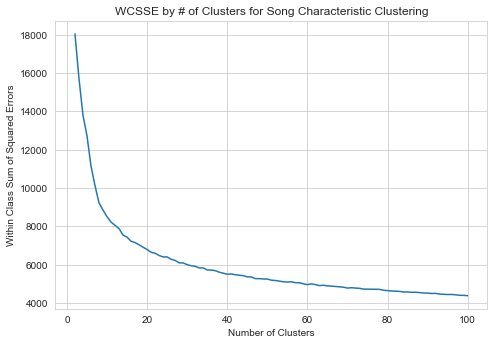

In [64]:
sns.set_style('whitegrid')
fig = plt.figure()
axes = fig.add_axes([0,0,1,1])
axes.plot(clusters,wcsse)
axes.set_xlabel('Number of Clusters')
axes.set_ylabel('Within Class Sum of Squared Errors')
axes.set_title('WCSSE by # of Clusters for Song Characteristic Clustering')

#### Fit a KMeans Model w/ 30 Clusters based off split point of WCSSE Graph above

In [65]:
kmeans = KMeans(n_clusters=30)
kmeans.fit(clean_characteristics)

KMeans(n_clusters=30)

In [66]:
song_characteristics['Cluster Label'] = kmeans.labels_

In [268]:
clean_characteristics.drop_duplicates(inplace=True)
song_characteristics = song_characteristics.loc[clean_characteristics.index]

In [271]:
def make_recommendation(song_characteristic_vector,cluster_model,all_songs,characteristics,num_recommendations):
     #copy to avoid broadcasting
    all_songs = all_songs.copy()
    song_characteristics = characteristics.copy()

    # ID Cluster for Song
    cluster = cluster_model.predict(song_characteristic_vector)[0]
    
    #Subset songs according to cluster assignment
    bool_indexer = all_songs['Cluster Label'] == cluster
    all_songs = all_songs[bool_indexer]
    song_characteristics = song_characteristics[bool_indexer]
    
    #Nearest Neighbors Search
    nn_search = NearestNeighbors(n_neighbors=len(all_songs))
    nn_search.fit(song_characteristics)
    #return distance for k closest songs in cluster , in this case will return distance to all songs in cluster
    distance, indices = nn_search.kneighbors(song_characteristic_vector)
    #order songs into distance order
    all_songs = all_songs.iloc[indices[0]]
    all_songs['Similarity'] = distance[0]
    all_songs['Similarity'] = all_songs['Similarity'].apply(lambda x:x if x>=0.0000001 else np.nan)
    #Normalize Distance
    all_songs['Similarity'] = round((all_songs['Similarity'].max() - all_songs['Similarity'])/(all_songs['Similarity'].max() - all_songs['Similarity'].min()),4)
    #Compute Recommendation Score
    all_songs['Recommendation Score'] = round(all_songs['Similarity']*all_songs['Popularity'],4)
    all_songs.sort_values('Recommendation Score',ascending = False,inplace=True)
    scores = all_songs['Recommendation Score'].copy()
    scores.drop_duplicates(inplace = True)
    all_songs = all_songs.loc[scores.index]
    all_songs = all_songs.iloc[:num_recommendations,[0,1,2,-2,-1]]
    all_songs.index = np.arange(1,num_recommendations + 1)
    
    display(all_songs)
    

#### Hip Hop Example: Drake, Laugh Now Cry Later

In [272]:
import time

In [273]:
timer = time.time()
make_recommendation(clean_characteristics.loc[[791]],kmeans,song_characteristics,clean_characteristics,5)
print(time.time() - timer)

,Artist Name,Track Name,Popularity,Similarity,Recommendation Score
1,Ariana Grande,34+35,0.88,0.9299,0.8183
2,Doja Cat,Kiss Me More (feat. SZA),0.98,0.8225,0.8060
3,Lil Nas X,MONTERO (Call Me By Your Name),1.00,0.7782,0.7782
4,MEDUZA,Paradise (feat. Dermot Kennedy),0.89,0.8661,0.7708
5,DJ Khaled,POPSTAR (feat. Drake),0.84,0.9121,0.7662


0.022883892059326172


#### Rock Example: Beatles, Let It Be

In [274]:
timer = time.time()
make_recommendation(clean_characteristics.loc[[2685]],kmeans,song_characteristics,clean_characteristics,5)
print(time.time() - timer)

,Artist Name,Track Name,Popularity,Similarity,Recommendation Score
1,The Beatles,Let It Be - Remastered 2009,0.78,0.9685,0.7554
2,Queen,We Will Rock You,0.78,0.9051,0.7060
3,Dire Straits,Romeo And Juliet,0.71,0.9541,0.6774
4,Fousheé,Deep End,0.79,0.8544,0.6750
5,Justin Bieber,Lonely (with benny blanco),0.84,0.7846,0.6591


0.02123880386352539


#### Blues Example: Muddy Waters, Mannish Boy

In [275]:
timer = time.time()
make_recommendation(clean_characteristics.loc[[6170]],kmeans,song_characteristics,clean_characteristics,5)
print(time.time() - timer)

,Artist Name,Track Name,Popularity,Similarity,Recommendation Score
1,Michael Kiwanuka,Cold Little Heart - Radio Edit,0.71,0.7480,0.5311
2,Mitski,Me and My Husband,0.78,0.6664,0.5198
3,Eric Clapton,Cocaine,0.70,0.7183,0.5028
4,Norman Greenbaum,Spirit In The Sky,0.75,0.6649,0.4987
5,Cream,Crossroads - Live,0.57,0.8647,0.4929


0.02202916145324707


#### Pop Example: Taylor Swift: Shake It Off

In [276]:
timer = time.time()
make_recommendation(clean_characteristics.loc[[9464]],kmeans,song_characteristics,clean_characteristics,5)
print(time.time() - timer)

,Artist Name,Track Name,Popularity,Similarity,Recommendation Score
1,AC/DC,You Shook Me All Night Long,0.80,0.8968,0.7174
2,Train,"Hey, Soul Sister",0.83,0.8599,0.7137
3,Nelly Furtado,Promiscuous,0.82,0.8642,0.7086
4,Bon Jovi,You Give Love A Bad Name,0.80,0.8788,0.7030
5,Counting Crows,Mr. Jones,0.77,0.9101,0.7008


0.022779226303100586


#### Metal Example: Black Sabbath, Iron Man

In [277]:
timer = time.time()
make_recommendation(clean_characteristics.loc[[9259]],kmeans,song_characteristics,clean_characteristics,5)
print(time.time() - timer)

,Artist Name,Track Name,Popularity,Similarity,Recommendation Score
1,Metallica,Enter Sandman,0.79,0.9215,0.7280
2,AC/DC,Highway to Hell,0.83,0.8482,0.7040
3,The Offspring,The Kids Aren't Alright,0.78,0.8844,0.6898
4,Avenged Sevenfold,Hail to the King,0.76,0.8839,0.6718
5,AC/DC,T.N.T.,0.78,0.8520,0.6646


0.021748065948486328


#### Indie Example: Arctic Monkeys, Do I Wanna Know?

In [278]:
timer = time.time()
make_recommendation(clean_characteristics.loc[[9092]],kmeans,song_characteristics,clean_characteristics,5)
print(time.time() - timer)

,Artist Name,Track Name,Popularity,Similarity,Recommendation Score
1,Train,Drops of Jupiter (Tell Me),0.78,0.9640,0.7519
2,Red Hot Chili Peppers,Under the Bridge,0.81,0.9026,0.7311
3,Queen,Bohemian Rhapsody - Remastered 2011,0.82,0.8612,0.7062
4,The Police,Every Little Thing She Does Is Magic,0.74,0.9021,0.6676
5,Ed Sheeran,Perfect,0.86,0.7733,0.6650


0.022832870483398438


#### Alternative Example: Coldplay, Yellow

In [279]:
timer = time.time()
make_recommendation(clean_characteristics.loc[[3966]],kmeans,song_characteristics,clean_characteristics,5)
print(time.time() - timer)

,Artist Name,Track Name,Popularity,Similarity,Recommendation Score
1,Keane,Somewhere Only We Know,0.77,1.0000,0.7700
2,Alan Walker,Fake A Smile,0.76,0.9929,0.7546
3,The Neighbourhood,Sweater Weather,0.89,0.8169,0.7270
4,Shawn Mendes,Wonder,0.80,0.8947,0.7158
5,Sia,Floating Through Space,0.82,0.8714,0.7145


0.024302959442138672


#### Visualization of Recommendation Scheme

In [189]:
tsne = TSNE(n_components=2)
lower_d_characteristics = tsne.fit_transform(X = clean_characteristics)

In [193]:
lower_d_characteristics = pd.DataFrame(lower_d_characteristics,columns = ['Component 1','Component 2'])
lower_d_characteristics['Cluster'] = list(song_characteristics['Cluster Label'])

In [215]:
np.random.seed(50)
cmap = {}
for num in range(30):
    cmap[num] = (np.random.random(),np.random.random(),np.random.random())

Text(0.5, 1.0, '2 Component TSNE Represenation of Music Characteristic-Based Clusters')

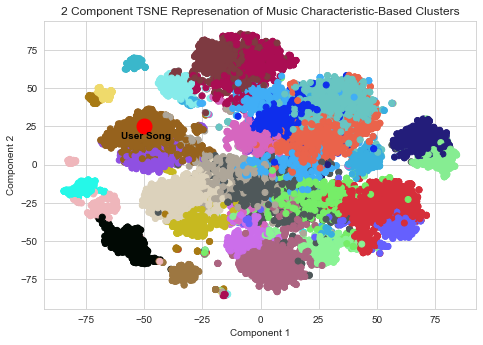

In [234]:
fig = plt.figure()
axes = fig.add_axes([0,0,1,1])
axes.scatter(lower_d_characteristics.iloc[:,0],lower_d_characteristics.iloc[:,1],c=lower_d_characteristics.iloc[:,2].map(cmap))
axes.scatter(-50,25,c='red',lw=10)
axes.text(-60,17,'User Song',fontweight = 'bold',c='black')
axes.set_xlabel('Component 1')
axes.set_ylabel('Component 2')
axes.set_title('2 Component TSNE Represenation of Music Characteristic-Based Clusters')

In [280]:
song_characteristics

,Artist Name,Track Name,Popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,...,Topic: Dating/Love,Topic: Emotion,Topic: Travel/Money,Topic: Time,Topic: Sensory Perception,Topic: Energize Audience,Topic: Other,Language Numeric Label,Language Label,Cluster Label
0,Escape the Fate,Unbreakable,0.47,0.563,0.820,-6.740,0.0489,0.00546,0.000579,0.1910,...,0.027565,0.088601,0.047031,0.252760,0.248434,0.010292,0.049903,2,English,2
1,COUCOU CHLOE,NOBODY,0.46,0.844,0.787,-7.044,0.1320,0.09410,0.000853,0.0841,...,0.068885,0.058713,0.148567,0.044459,0.010206,0.024751,0.063610,2,English,3
2,beabadoobee,Worth It,0.51,0.576,0.751,-5.256,0.0269,0.01250,0.000459,0.0501,...,0.393703,0.074901,0.052738,0.059970,0.007123,0.035655,0.136168,2,English,6
3,Andrew Broder,Bloodrush,0.39,0.693,0.613,-10.160,0.2610,0.07980,0.000137,0.1080,...,0.048232,0.029159,0.272287,0.009092,0.026298,0.021253,0.077792,2,English,27
4,Greta Van Fleet,Age Of Man,0.56,0.460,0.601,-5.486,0.0304,0.03770,0.715000,0.0954,...,0.064206,0.146157,0.271352,0.006754,0.296127,0.015577,0.034879,2,English,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19370,Woolbright,Tuesday,0.23,0.514,0.819,-6.713,0.0375,0.01220,0.015800,0.2830,...,0.052906,0.048205,0.307872,0.272475,0.069767,0.018168,0.048128,2,English,2
19371,Runnin' Wild,How You Want It Done,0.27,0.614,0.953,-3.539,0.0517,0.07710,0.033300,0.3720,...,0.096237,0.041940,0.065284,0.013503,0.038043,0.043978,0.082588,2,English,27
19372,Four Year Strong,Go Down in History,0.48,0.505,0.985,-4.401,0.1190,0.00006,0.000010,0.3510,...,0.107178,0.028838,0.286602,0.257519,0.010463,0.017033,0.046707,2,English,2
19373,Nathaniel Rateliff & The Night Sweats,S.O.B.,0.66,0.699,0.579,-6.504,0.0416,0.26700,0.006020,0.4520,...,0.063016,0.159672,0.235609,0.026717,0.012714,0.037421,0.086819,2,English,6


In [281]:
clean_characteristics

,Topic: Family/Religion,Topic: Music,Topic: Violence,Topic: Explicit Content,Topic: Dating/Love,Topic: Emotion,Topic: Travel/Money,Topic: Time,Topic: Sensory Perception,Topic: Energize Audience,...,Finnish,French,German,Italian,Kinyarwanda,Other,Portuguese,Romanian,Spanish,Swedish
0,0.021344,0.005689,0.234788,0.013593,0.027565,0.088601,0.047031,0.252760,0.248434,0.010292,...,0,0,0,0,0,0,0,0,0,0
1,0.022101,0.011105,0.010150,0.537453,0.068885,0.058713,0.148567,0.044459,0.010206,0.024751,...,0,0,0,0,0,0,0,0,0,0
2,0.016258,0.012419,0.027000,0.184066,0.393703,0.074901,0.052738,0.059970,0.007123,0.035655,...,0,0,0,0,0,0,0,0,0,0
3,0.039783,0.038527,0.214503,0.223075,0.048232,0.029159,0.272287,0.009092,0.026298,0.021253,...,0,0,0,0,0,0,0,0,0,0
4,0.067242,0.024134,0.059046,0.014527,0.064206,0.146157,0.271352,0.006754,0.296127,0.015577,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19370,0.038967,0.062644,0.012486,0.068384,0.052906,0.048205,0.307872,0.272475,0.069767,0.018168,...,0,0,0,0,0,0,0,0,0,0
19371,0.057066,0.039681,0.234731,0.286949,0.096237,0.041940,0.065284,0.013503,0.038043,0.043978,...,0,0,0,0,0,0,0,0,0,0
19372,0.027555,0.006306,0.143257,0.068540,0.107178,0.028838,0.286602,0.257519,0.010463,0.017033,...,0,0,0,0,0,0,0,0,0,0
19373,0.067495,0.004925,0.193993,0.111621,0.063016,0.159672,0.235609,0.026717,0.012714,0.037421,...,0,0,0,0,0,0,0,0,0,0
